In [122]:
import pandas as pd
import re
import gensim
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
#import matplotlib.pyplot as plt
#%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
data = r'data/all_ECB_speeches.csv'

In [6]:
df = pd.read_csv(data,sep='|')
df.head()

,date,speakers,title,subtitle,contents
0,2021-10-20,Frank Elderson,Overcoming the tragedy of the horizon: requiri...,"Keynote speech by Frank Elderson, Member of th...",SPEECH Overcoming the tragedy of the horiz...
1,2021-10-19,Fabio Panetta,“Hic sunt leones” – open research questions on...,"Speech by Fabio Panetta, Member of the Executi...",SPEECH “Hic sunt leones” – open research q...
2,2021-10-19,Frank Elderson,The role of supervisors and central banks in t...,"Keynote speech by Frank Elderson, Member of th...",SPEECH The role of supervisors and central...
3,2021-10-16,Christine Lagarde,Globalisation after the pandemic,2021 Per Jacobsson Lecture by Christine Lagard...,SPEECH Globalisation after the pandemic ...
4,2021-10-14,Christine Lagarde,IMFC Statement,"Statement by Christine Lagarde, President of t...",SPEECH IMFC Statement Statement by Chri...


In [10]:
df.speakers.unique().tolist()

['Frank Elderson',
 'Fabio Panetta',
 'Christine Lagarde',
 'Philip R. Lane',
 'Isabel Schnabel',
 'Luis de Guindos',
 nan,
 'Yves Mersch',
 'Benoît Cœuré',
 'Sabine Lautenschläger',
 'Mario Draghi',
 'Peter Praet',
 'Vítor Constâncio',
 'Jörg Asmussen',
 'José Manuel González-Páramo',
 'Lorenzo Bini Smaghi',
 'Jürgen Stark',
 'Jean-Claude Trichet',
 'Gertrude Tumpel-Gugerell',
 'Lucas Papademos',
 'Otmar Issing',
 'Tommaso Padoa-Schioppa',
 'Eugenio Domingo Solans',
 'Willem F. Duisenberg',
 'Sirkka Hämäläinen',
 'Christian Noyer',
 'Willem F. Duisenberg,Eugenio Domingo Solans',
 'Alexandre Lamfalussy']

In [11]:
len(df.index)

2526

<AxesSubplot:>

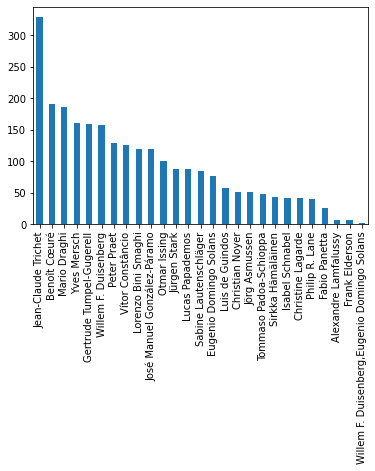

In [16]:
df.speakers.value_counts().plot(kind='bar')

In [21]:
df.subtitle[1500]

'Remarks by Jean-Claude Trichet President of the ECB at the ceremony of the European Parliament to mark the 10th anniversary of the euro Strasbourg, 13 January 2009'

In [132]:
df=df.dropna(subset=['contents'])

In [133]:
data = df.contents.tolist()

In [129]:
def preprocess(data):
    # creating a list for appending the preprocessed text
    data_list = []
    # iterating through all the text
    for text in data:
        # removing the symbols and numbers
        try:
            text = re.sub(r'[!@#$()--–,“”".%^*?:;~`0-9]', ' ', text)
            text = re.sub(r"[\([{})\]]", '', text)
            text = re.sub('\s+', ' ', text)
            # converting the text to lower case
            text = text.lower()
            # appending to data_list
            data_list.append(text)
        except TypeError as e:
            print(e)
            print(text)
            pass
    return data_list

In [86]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [93]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [134]:
data_prep = preprocess(data)

In [84]:
data_prep[1]

' speech hic sunt leones open research questions on the international dimension of central bank digital currencies speech by fabio panetta member of the executive board of the ecb at the ecb cebra conference on international aspects of digital currencies and fintech frankfurt am main october it is a pleasure to welcome you on behalf of the european central bank ecb to the fifth annual meeting of the international finance and macroeconomics program of the central bank research association cebra this year’s meeting is taking place virtually and it brings together participants from nearly time zones which is fitting for a conference that seeks to shed light on how digitalisation is changing money and finance globally in my remarks today i will focus on the international dimension of central bank digital currencies or cbdcs the ecb launched an investigation phase for the digital euro over the summer one of the aspects we are investigating is whether it would be possible to use the digital 

In [89]:
data_words = list(sent_to_words(data_prep))

print(data_words[:1])

[['speech', 'overcoming', 'the', 'tragedy', 'of', 'the', 'horizon', 'requiring', 'banks', 'to', 'translate', 'targets', 'into', 'milestones', 'keynote', 'speech', 'by', 'frank', 'elderson', 'member', 'of', 'the', 'executive', 'board', 'of', 'the', 'ecb', 'and', 'vice', 'chair', 'of', 'the', 'supervisory', 'board', 'of', 'the', 'ecb', 'at', 'the', 'financial', 'market', 'authority', 'supervisory', 'conference', 'vienna', 'october', 'introduction', 'it', 'is', 'great', 'pleasure', 'for', 'me', 'to', 'speak', 'here', 'and', 'would', 'like', 'to', 'thank', 'the', 'organisers', 'for', 'inviting', 'me', 'today', 'want', 'to', 'look', 'ahead', 'to', 'next', 'year', 'to', 'the', 'next', 'five', 'years', 'and', 'to', 'the', 'three', 'decades', 'up', 'to', 'the', 'year', 'by', 'which', 'the', 'eu', 'has', 'pledged', 'to', 'become', 'carbon', 'neutral', 'under', 'the', 'paris', 'agreement', 'thirty', 'years', 'is', 'hair', 'breadth', 'of', 'time', 'merely', 'one', 'hundred', 'and', 'fifty', 'mill

In [90]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['speech', 'overcoming', 'the', 'tragedy', 'of', 'the', 'horizon', 'requiring', 'banks', 'to', 'translate', 'targets', 'into', 'milestones', 'keynote_speech', 'by', 'frank_elderson', 'member', 'of', 'the', 'executive_board', 'of', 'the', 'ecb', 'and', 'vice_chair', 'of', 'the', 'supervisory', 'board', 'of', 'the', 'ecb', 'at', 'the', 'financial', 'market', 'authority', 'supervisory', 'conference', 'vienna', 'october', 'introduction', 'it', 'is', 'great_pleasure', 'for', 'me', 'to', 'speak', 'here', 'and', 'would', 'like', 'to', 'thank', 'the', 'organisers', 'for', 'inviting_me', 'today', 'want', 'to', 'look', 'ahead', 'to', 'next', 'year', 'to', 'the', 'next', 'five', 'years', 'and', 'to', 'the', 'three', 'decades', 'up', 'to', 'the', 'year', 'by', 'which', 'the', 'eu', 'has', 'pledged', 'to', 'become', 'carbon_neutral', 'under', 'the', 'paris_agreement', 'thirty', 'years', 'is', 'hair', 'breadth', 'of', 'time', 'merely', 'one', 'hundred', 'and', 'fifty', 'millionth', 'of', 'the', 'ear

In [98]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['speech', 'overcome', 'tragedy', 'horizon', 'require', 'bank', 'translate', 'target', 'milestone', 'member', 'executive_board', 'board', 'financial', 'market', 'supervisory', 'conference', 'introduction', 'speak', 'would', 'like', 'thank', 'organiser', 'invite', 'today', 'want', 'look', 'ahead', 'next', 'year', 'year', 'decade', 'year', 'pledge', 'become', 'agreement', 'year', 'hair', 'breadth', 'time', 'merely', 'millionth', 'earth', 'year', 'existence', 'brief', 'span', 'indeed', 'doubt', 'time', 'run', 'tackle', 'climate', 'environmental', 'crisis', 'mean', 'bank', 'mean', 'time', 'preparation', 'time', 'action', 'bank', 'need', 'start', 'think', 'next', 'important', 'step', 'risk', 'management', 'require', 'look', 'year', 'ahead', 'devise', 'intermediate', 'target', 'risk', 'exposure', 'render', 'fit', 'carbon_neutral', 'economy', 'bank', 'long', 'simply', 'declare', 'intention', 'compliant', 'must', 'make', 'structural', 'change', 'way', 'business', 'make', 'sure', 'actually', '

In [101]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 7), (7, 1), (8, 1), (9, 1), (10, 1), (11, 4), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 3), (20, 2), (21, 2), (22, 5), (23, 1), (24, 1), (25, 1), (26, 3), (27, 4), (28, 1), (29, 1), (30, 1), (31, 3), (32, 2), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 7), (41, 3), (42, 1), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 2), (49, 70), (50, 3), (51, 2), (52, 1), (53, 4), (54, 1), (55, 2), (56, 2), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 4), (67, 10), (68, 2), (69, 7), (70, 1), (71, 1), (72, 6), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 5), (81, 1), (82, 1), (83, 1), (84, 4), (85, 1), (86, 16), (87, 1), (88, 1), (89, 1), (90, 3), (91, 1), (92, 1), (93, 3), (94, 1), (95, 3), (96, 2), (97, 2), (98, 2), (99, 2), (100, 1), (101, 7), (102, 3), (103, 1), (104, 3), (105, 1), (106, 2), (107, 1), (108, 3), (109, 2), (110,

In [102]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('accordingly', 1),
  ('account', 1),
  ('achieve', 1),
  ('acknowledge', 1),
  ('acknowledgement', 1),
  ('action', 7),
  ('activity', 1),
  ('actually', 1),
  ('adapt', 1),
  ('adaptation', 1),
  ('addition', 4),
  ('address', 1),
  ('adequate', 2),
  ('adjust', 1),
  ('adopt', 1),
  ('advance', 1),
  ('advise', 1),
  ('affect', 2),
  ('agreement', 3),
  ('ahead', 2),
  ('align', 2),
  ('alignment', 5),
  ('alliance', 1),
  ('allow', 1),
  ('almost', 1),
  ('already', 3),
  ('also', 4),
  ('ambition', 1),
  ('ambitious', 1),
  ('analyse', 1),
  ('analysis', 3),
  ('annual', 2),
  ('apply', 1),
  ('approach', 1),
  ('appropriate', 2),
  ('area', 1),
  ('arise', 1),
  ('arrangement', 1),
  ('ask', 1),
  ('assess', 7),
  ('assessment', 3),
  ('asset', 1),
  ('assigning', 1),
  ('associate', 2),
  ('authority', 2),
  ('automatically', 1),
  ('avert', 1),
  ('avoid', 2),
  ('bank', 70),
  ('banking', 3),
  ('base', 2),
  ('basis', 1),
  ('become', 4),
  ('believe', 1),
  

In [119]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [120]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"integration" + 0.019*"payment" + 0.015*"market" + 0.014*"system" + '
  '0.013*"european" + 0.010*"single" + 0.009*"also" + 0.009*"service" + '
  '0.009*"area" + 0.008*"process"'),
 (1,
  '0.045*"growth" + 0.034*"area" + 0.020*"labour" + 0.017*"increase" + '
  '0.017*"economic" + 0.016*"reform" + 0.016*"market" + 0.016*"country" + '
  '0.014*"structural" + 0.014*"productivity"'),
 (2,
  '0.035*"inflation" + 0.031*"policy" + 0.028*"rate" + 0.019*"monetary" + '
  '0.013*"price" + 0.012*"may" + 0.012*"interest" + 0.011*"effect" + '
  '0.011*"see" + 0.010*"real"'),
 (3,
  '0.046*"policy" + 0.042*"monetary" + 0.027*"stability" + 0.026*"price" + '
  '0.015*"central" + 0.012*"economic" + 0.011*"strategy" + 0.010*"bank" + '
  '0.009*"term" + 0.009*"ecb"'),
 (4,
  '0.079*"household" + 0.064*"income" + 0.057*"saving" + 0.036*"housing" + '
  '0.035*"asset" + 0.032*"wealth" + 0.026*"chart" + 0.026*"mortgage" + '
  '0.023*"consumption" + 0.022*"investment"'),
 (5,
  '0.087*"currency" 

In [126]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
#vis

/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi